<a href="https://colab.research.google.com/github/bw-spotify2/ds/blob/master/Song_Selector_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Lambda/Unit 4/Sprint 4/SpotifyFeatures.csv')
df.sample(10)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
14414,Dance,KREAM,Deep End (feat. JHart) - Eden Prince Remix,3K4ywyPCdpF9evoL7Z3z1b,72,0.015400,0.677,208096,0.8480,0.001110,G,0.2770,-6.140,Minor,0.0741,125.068,4/4,0.4690
21695,Dance,Trey Songz,Unusual - feat. Drake,51q0vXgCI2CW9x4K8SdfXS,46,0.182000,0.591,212347,0.6580,0.000000,C,0.6150,-5.881,Minor,0.1950,81.933,4/4,0.6230
230008,Soul,HONNE,Treat You Right,0TrCJBaSXFSaO622CbGV03,37,0.002550,0.602,242243,0.6850,0.000072,G,0.2650,-5.992,Major,0.0402,99.998,4/4,0.3890
29863,Anime,Ikimonogakari,Kimagure Romantic,46jFfrQdRnKSb4uuPDQSne,33,0.111000,0.484,242880,0.8860,0.000000,D,0.3150,-2.544,Major,0.0542,170.134,4/4,0.6990
218731,World,Shakuhachi Sakano,Brainwave Connections,3vn9qbBDIXhVh15kjQCVtn,4,0.858000,0.169,225875,0.0295,0.826000,C,0.1050,-29.656,Major,0.0522,128.966,4/4,0.0336
111595,Pop,Nine Days,Absolutely (Story of a Girl) - Radio Mix,3mNecsYFb6LQg7822DPXCP,66,0.000891,0.481,189333,0.9400,0.000000,G,0.0939,-5.204,Major,0.0660,96.493,4/4,0.6600
11130,Alternative,Brand Nubian,Slow Down,6i4Gu9ogL4kClgBzj3NZ6g,49,0.079800,0.731,303040,0.8570,0.000009,A,0.0772,-13.358,Major,0.1900,95.879,4/4,0.6910
106067,Opera,Gioachino Rossini,"Rossini: Il barbiere di Siviglia, Act 1 Scene ...",7vQllMpGPF5chmLHcJDk6T,3,0.958000,0.480,488133,0.1250,0.000072,G,0.2570,-21.825,Major,0.0520,106.478,4/4,0.3140
222648,Rock,Chase Rice,Ride (feat. Macy Maloy),1CoOHJAHtKEDnUBrp3nKAB,65,0.037400,0.666,241240,0.6940,0.000000,A#,0.1240,-7.184,Major,0.0333,115.070,4/4,0.3540
134362,Reggae,Katastro,Voices,76eyiBTmKPg3rAvpCUeKO2,28,0.246000,0.832,153226,0.7070,0.000925,G,0.1750,-6.969,Major,0.0381,94.010,4/4,0.3500


In [ ]:
!pip install spotipy --upgrade
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time 

client_id = '14f59f665a094868921bdd76e420d7c0'
client_secret = '5e16ddb0f2ed45a69949330bbd34351a'
username = 'mahoryu'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
def getTrackFeatures(X):
  X = X.copy()

  for i in range(len(X['track_id'])):
    meta = sp.track(X['track_id'][i])
    features = sp.audio_features(X['track_id'][i])

    X['mode'][i] = features[0]['mode']
    X['key'][i] = features[0]['key']
    X['time_signature'][i] = features[0]['time_signature']

  return X

In [ ]:
df_test = df[:500]
df_test.shape

(500, 18)

In [ ]:
df_new = getTrackFeatures(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_new.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4,0.390


In [ ]:
headers = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']
df_new = df_new[headers]

In [ ]:
df_new.shape

(500, 14)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

Using TensorFlow backend.


In [ ]:
# Normalise
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_new)

In [ ]:
df_scaled = pd.DataFrame(data_scaled,columns=headers)
df_scaled.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.000000,0.613844,0.364176,0.022303,0.932270,0.000,0.090909,0.335112,1.000000,1.0,0.031243,0.777809,0.75,0.836588
1,0.013158,0.246796,0.607606,0.032821,0.754736,0.000,0.545455,0.127001,0.840868,0.0,0.067818,0.818418,0.75,0.838643
2,0.039474,0.956759,0.696016,0.041927,0.132853,0.000,0.000000,0.075774,0.486010,0.0,0.013862,0.388220,1.00,0.378212
3,0.000000,0.706361,0.183723,0.036988,0.332964,0.000,0.090909,0.070971,0.558560,1.0,0.017381,0.805457,0.75,0.233299
4,0.052632,0.954747,0.293932,0.017667,0.229317,0.125,0.454545,0.181430,0.175894,1.0,0.023886,0.625434,0.75,0.400822


In [ ]:
# Fixed dimensions
input_dim = df_new.shape[1]  # 14

# Number of neurons in each Layer [14, 7, 4, 2, ...] of encoders
input_layer = Input(shape=(input_dim, ))
encoder_layer_1 = Dense(7, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder_layer_2 = Dense(4, activation="relu")(encoder_layer_1)
encoder_layer_3 = Dense(2, activation="relu")(encoder_layer_2)

# Crear encoder model
encoder = Model(inputs=input_layer, outputs=encoder_layer_3)

decoder_1 = Dense(4, activation='relu')(encoder_layer_3)
decoder_2 = Dense(7, activation='relu')(decoder_1)
decoder_output = Dense(14, activation = 'softmax')(decoder_2)

autoencoder = Model(input_layer, decoder_output)

autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 14)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_42 (Dense)             (None, 7)                 35        
_________________________________________________________________
dense_43 (Dense)             (None, 14)                112

In [ ]:

autoencoder.compile(optimizer='nadam',
                    loss='mean_squared_error',
                    metrics=['mae'])

autoencoder.fit(df_scaled, df_scaled,
                epochs=100,
                batch_size=32)
                # shuffle=True,
                # validation_data=(x_test, x_test),
                # verbose = 1,
                # callbacks=[stop, tensorboard])

Epoch 1/100
500/500 [==============================] - 0s 594us/step - loss: 0.2360 - mae: 0.3689
Epoch 2/100
500/500 [==============================] - 0s 185us/step - loss: 0.2321 - mae: 0.3659
Epoch 3/100
500/500 [==============================] - 0s 196us/step - loss: 0.2272 - mae: 0.3614
Epoch 4/100
500/500 [==============================] - 0s 202us/step - loss: 0.2190 - mae: 0.3553
Epoch 5/100
500/500 [==============================] - 0s 191us/step - loss: 0.2132 - mae: 0.3543
Epoch 6/100
500/500 [==============================] - 0s 191us/step - loss: 0.2111 - mae: 0.3552
Epoch 7/100
500/500 [==============================] - 0s 197us/step - loss: 0.2097 - mae: 0.3548
Epoch 8/100
500/500 [==============================] - 0s 184us/step - loss: 0.2085 - mae: 0.3541
Epoch 9/100
500/500 [==============================] - 0s 193us/step - loss: 0.2073 - mae: 0.3530
Epoch 10/100
500/500 [==============================] - 0s 191us/step - loss: 0.2063 - mae: 0.3520
Epoch 11/100
500/50

In [ ]:

# Use the model to predict the factors which sum up the information of interest rates.
encoded_data = pd.DataFrame(encoder.predict(data_scaled))
encoded_data.columns = ['x', 'y']
encoded_data.head()

,x,y
0,2.939129,1.748975
1,1.269577,1.530359
2,1.006620,1.220819
3,3.210500,1.766507
4,1.731930,0.000000


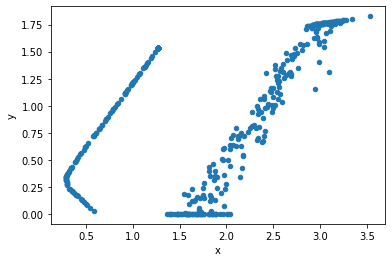

In [ ]:
encoded_data.plot.scatter('x','y')

In [ ]:
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, b)

5.196152422706632

In [ ]:
for i in range(len(encoded_data['x'])):
  encoded_data['e_distance'][i] = distance.euclidean((encoded_data['x'][i],encoded_data['y'][i]),(2.939129,1.748975))
encoded_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,y,e_distance
0,2.939129,1.748975,4.052917e-07
1,1.269577,1.530359,1.683805e+00
2,1.006620,1.220819,2.003382e+00
3,3.210500,1.766507,2.719365e-01
4,1.731930,0.000000,2.125146e+00


In [ ]:
encoded_data['e_distance'].nsmallest(5)

0      4.052917e-07
464    3.401462e-04
244    1.047523e-03
30     4.350866e-03
266    5.536097e-03
Name: e_distance, dtype: float64

In [ ]:
print(df['track_name'][0])
print(df['track_name'][464])
print(df['track_name'][30])

C'est beau de faire un Show
Je n'ai pas su te prendre te comprendre
A ty się śmiejesz ze mnie


In [ ]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [ ]:
df.iloc[464:465]


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
464,Movie,Bernard Minet,Je n'ai pas su te prendre te comprendre,44omvGaxtWafrOl2Z0YKy0,1,0.326,0.695,241027,0.967,0.00681,C,0.298,-6.243,Major,0.0338,129.984,4/4,0.962


In [ ]:
df.iloc[0:1]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.91,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814


In [ ]:
import plotly.express as px
df = px.data.wind()
fig = px.scatter_polar(df, r="frequency", theta="direction",
                       color="strength", symbol="strength", size="frequency",
                       color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.show()

In [ ]:
df_T = df_scaled.T

In [ ]:
import plotly.express as px

fig = px.bar_polar(df_T, r = 0,hover_name=headers)
fig.show()

In [ ]:
fig = px.bar_polar(df_T, r = 464, hover_name=headers)
fig.show()